In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

# Set device (M3 GPU or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [9]:
# Define paths to your dataset
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')

# Define basic transforms (we'll add augmentations later)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Get number of classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.classes}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Number of classes: 38
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_sp

In [11]:
# Model 1: Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # For 224x224 input
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model 1
model1 = SimpleCNN(num_classes).to(device)

# Model 2: Pre-trained ResNet18
model2 = models.resnet18(weights=ResNet18_Weights.DEFAULT)  # Modern syntax
model2.fc = nn.Linear(model2.fc.in_features, num_classes)  # Adapt for num_classes
model2 = model2.to(device)

In [12]:
def train_model(model, train_loader, val_loader, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true.extend(labels.numpy())
    
    acc = accuracy_score(true, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, average='weighted')
    return acc, prec, rec, f1

In [15]:
# Train Model 1 (Simple CNN)
print("Training Simple CNN...")
acc1, prec1, rec1, f1_1 = train_model(model1, train_loader, val_loader)
print(f"Simple CNN - Accuracy: {acc1:.4f}, Precision: {prec1:.4f}, Recall: {rec1:.4f}, F1: {f1_1:.4f}")

# Train Model 2 (ResNet18)
print("\nTraining ResNet18...")
acc2, prec2, rec2, f1_2 = train_model(model2, train_loader, val_loader)
print(f"ResNet18 - Accuracy: {acc2:.4f}, Precision: {prec2:.4f}, Recall: {rec2:.4f}, F1: {f1_2:.4f}")

Training Simple CNN...
Epoch 1/5, Loss: 0.7508
Epoch 2/5, Loss: 0.4317
Epoch 3/5, Loss: 0.3577
Epoch 4/5, Loss: 0.3230
Epoch 5/5, Loss: 0.2876
Simple CNN - Accuracy: 0.9173, Precision: 0.9221, Recall: 0.9173, F1: 0.9175

Training ResNet18...
Epoch 1/5, Loss: 0.0791
Epoch 2/5, Loss: 0.0628
Epoch 3/5, Loss: 0.0550
Epoch 4/5, Loss: 0.0475
Epoch 5/5, Loss: 0.0459
ResNet18 - Accuracy: 0.9915, Precision: 0.9916, Recall: 0.9915, F1: 0.9915


In [14]:
# Augmented transforms for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Update train dataset with augmentation
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [16]:
torch.save(model1.state_dict(), 'simple_cnn.pth')
torch.save(model2.state_dict(), 'resnet18.pth')

Testing Simple CNN:


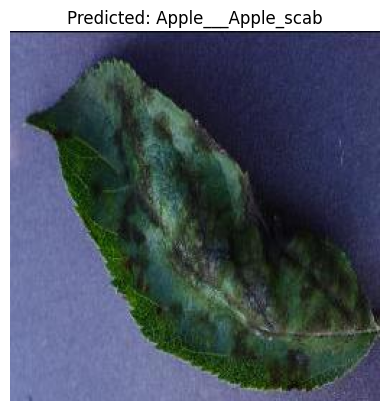

Testing ResNet18:


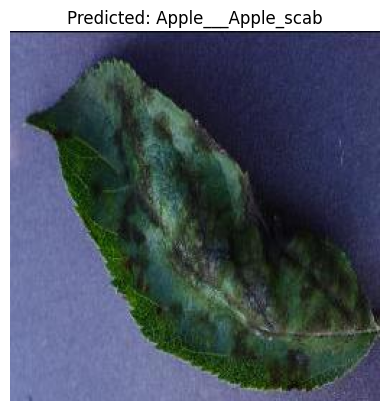

'Apple___Apple_scab'

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(model, image_path, transform, class_names):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Predict
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]
    
    # Display image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    return predicted_class

# Get class names from dataset
class_names = train_dataset.classes

# Test on a sample image
sample_image_path = os.path.join(val_dir, class_names[0], os.listdir(os.path.join(val_dir, class_names[0]))[0])
print("Testing Simple CNN:")
predict_image(model1, sample_image_path, transform, class_names)
print("Testing ResNet18:")
predict_image(model2, sample_image_path, transform, class_names)

In [18]:
model2.to(device)  # Ensure model is on MPS
torch.save(model2.state_dict(), 'resnet18.pth')  # Overwrite with MPS weights

In [19]:
# After training model2
model2.to(device)  # Explicitly move to MPS
torch.save(model2.state_dict(), 'resnet18.pth')  # Save with MPS weights
print("Model saved with device:", next(model2.parameters()).device)

Model saved with device: mps:0
